In [1]:
# import Glop linear solver package
from ortools.linear_solver import pywraplp as glp

In [2]:
# model parameters
plant = ['Cleveland','Nashville','St.Louis', 'Milwaukee']
rdc = ['Scranton','Atlanta','Reno']
fixed_cost = [320, 175, 300, 0] # fixed cost of operating each plant in thousand $
capacity = [30, 15, 30, 25]  # capacity of each plant in thousand units
demand = [20, 10, 25]  # demand at each RDC in thousand units
transp_cost = [[ 2, 6, 10],  # transportation cost per unit from Detroit to each RDC
               [ 3, 4, 9], 
               [ 5, 9, 7],  
               [ 5,10, 8]]  # St. Louis to RDCs

In [3]:
# initialize model object
mymodel = glp.Solver('Scott Office Product' ,glp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)


In [4]:
# create shipment variables
ship = list(range(len(plant)))
for i in range(len(plant)):
    ship[i] = list(range(len(plant)))
    for j in range(len(rdc)):
        ship[i][j] = mymodel.NumVar(0, mymodel.infinity(), plant[i] + ' to ' + rdc[j])

In [5]:
#create plant selection variables
select = list(range(len(plant)))
for i in range(len(plant)):
    select[i] = mymodel.IntVar(0,1, plant[i])

In [6]:
# create objective function
tot_cost = mymodel.Objective()
tot_cost.SetMinimization()

#Shipment variables
for i in range(len(plant)):
    for j in range(len(rdc)):
        tot_cost.SetCoefficient(ship[i][j], transp_cost[i][j])
        
#Binary Selection variables
for i in range(len(plant)):
    tot_cost.SetCoefficient(select[i], fixed_cost[i])

In [7]:
# rdc demand constraints
demand_constr = list(range(len(rdc)))
for j in range(len(rdc)):
    demand_constr[j] = mymodel.Constraint(demand[j], demand[j])
    for i in range(len(plant)):
        demand_constr[j].SetCoefficient(ship[i][j], 1)

In [8]:
# plant supply constraints
supply_constr = list(range(len(plant)))
for i in range(len(plant)):
    supply_constr[i] = mymodel.Constraint(-mymodel.infinity(), 0)
    supply_constr[i].SetCoefficient(select[i], -capacity[i])
    for j in range(len(rdc)):
        supply_constr[i].SetCoefficient(ship[i][j], 1)

In [9]:
# Solve the model and print optimal solution
status = mymodel.Solve()                 # solve mymodel and display the solution

print('Solution Status =', status)
print('Number of variables =', mymodel.NumVariables())
print('Number of constraints =', mymodel.NumConstraints())

print('Optimal Solution:')

# The objective value of the solution.
print('Optimal Value = %.6f' % tot_cost.Value())

Solution Status = 0
Number of variables = 16
Number of constraints = 7
Optimal Solution:
Optimal Value = 620.000000


In [10]:
#display solution
for i in range(len(plant)):
    if select[i].solution_value() == 0: continue
    print (plant[i])
    for j in range(len(rdc)):
        if ship[i][j].solution_value()!=0:
            print('\t %7s %6.2f' % (rdc[j], ship[i][j].solution_value()))

Cleveland
	 Scranton  20.00
	 Atlanta  10.00
Milwaukee
	    Reno  25.00


In [11]:
# display plant supply constraint information
print('Constraint \t LHS \t RHS \t Slack')
LHS = mymodel.ComputeConstraintActivities()
for i in range(len(plant)):
    rhs = select[i].solution_value() * capacity[i]
    lhs = LHS[i + len(rdc)] + rhs
    slack = rhs - lhs
    print('%11s \t %4.1f \t %4.1f \t %4.1f' % (plant[i], lhs, rhs, slack))

Constraint 	 LHS 	 RHS 	 Slack
  Cleveland 	 30.0 	 30.0 	  0.0
  Nashville 	  0.0 	  0.0 	  0.0
   St.Louis 	  0.0 	  0.0 	  0.0
  Milwaukee 	 25.0 	 25.0 	  0.0


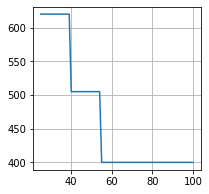

In [15]:
import matplotlib.pyplot as plt

# optimization parameter analysis: Milwaukee capacity (25,000 - 100,000)

stl_cap = list(range(25, 101))
stl_totcost = list(range(len(stl_cap)))

for k in range(len(stl_cap)):
    supply_constr[3].SetCoefficient(select[3], -stl_cap[k])
    mymodel.Solve()
    stl_totcost[k] = tot_cost.Value()
supply_constr[3].SetCoefficient(select[3], -capacity[3])

(fig, ax) = plt.subplots(1, 1, figsize = (3,3))
ax.grid(True)
ax.plot(stl_cap, stl_totcost)
plt.show()
#=> The plant in Milwaukee will take on more demand, and since
# Milwaukee inherently has no fixed cost, thus it will
#decrease the total cost of the operation.
# By the time Milwaukee's capacity hit somewhere between 50,000 and 60,000
#The cost will hits minimum, plateauing at 400,000, with Milwaukee taking
# on all of the demand

In [17]:
#reset to original optimal solution
mymodel.Solve()

#display solution
print('Optimal Value =', tot_cost.Value())
for i in range(len(plant)):
    if select[i].solution_value() == 1:
        print(plant[i])
        for j in range(len(rdc)):
            if ship[i][j].solution_value() != 0:
                print('\t %7s %6.2f' % (rdc[j], ship[i][j].solution_value())) 

Optimal Value = 620.0
Cleveland
	 Scranton  20.00
	 Atlanta  10.00
Milwaukee
	    Reno  25.00


In [18]:
# store coefficients and RHS for cut constraint
# -select[0] - select[1] - select[2] + select[3] + select[4] <=2-1
# 0-1-0+1+1<=1
a = list()
M = 0

for i in range(len(select)):
    if select[i].solution_value() == 1:
        a.append(1)
        M+=1
    elif select[i].solution_value() == 0:
        a.append(-1)
print(M, a)


2 [1, -1, -1, 1]


In [19]:
#add cut constraint
cut_constr = mymodel.Constraint(-mymodel.infinity(), M-1)
for i in range(len(plant)):
    cut_constr.SetCoefficient(select[i], a[i])

    
#re-optimize and display next solution
mymodel.Solve()
print('Optimal Value =', tot_cost.Value())
for i in range(len(plant)):
    if select[i].solution_value() == 1:
        print(plant[i])
        for j in range(len(rdc)):
            if ship[i][j].solution_value() != 0:
                print('\t %7s %6.2f' % (rdc[j], ship[i][j].solution_value())) 
            
# relax cut constraint
cut_constr.SetBounds(-mymodel.infinity(),mymodel.infinity())

Optimal Value = 670.0
St.Louis
	 Atlanta   5.00
	    Reno  25.00
Milwaukee
	 Scranton  20.00
	 Atlanta   5.00
